## Import libraries and load data

In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Load the train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display basic info
print(train_df.shape, test_df.shape)
train_df.head()


(8000, 4) (2000, 3)


,movie_id,title,overview,genre_ids
0,1162,They Call Me Trinity,The simple story has the pair coming to the re...,"[28, 35, 37]"
1,3425,Lone Star,When the skeleton of his murdered predecessor ...,"[18, 9648, 10749]"
2,8515,AVP: Alien vs. Predator,When scientists discover something near Antarc...,"[12, 878, 28, 27]"
3,3619,Wristcutters: A Love Story,"Zia, distraught over breaking up with his girl...","[35, 18, 14, 10749]"
4,6080,The Pickup,A routine cash pickup takes a wild turn when m...,"[28, 35, 80]"


 ##  Data preprocessing - Extract features and multilabel genres

In [19]:
import ast

# Plot summaries as feature
X_train_text = train_df['overview'].fillna('')

# Multilabel genres in 'genreids' as string representations of Python lists like "[28, 35, 37]"
y_train_labels = train_df['genre_ids'].fillna('[]')

# Parse genre_ids from stringified lists to actual lists of ints
def parse_genre_list(s):
    try:
        genres = ast.literal_eval(s)
        if isinstance(genres, list):
            return genres
        else:
            return []
    except:
        return []

y_train_lists = y_train_labels.apply(parse_genre_list)

# Extract unique genre ids for multilabel binarization
all_genres = set()
for genres in y_train_lists:
    all_genres.update(genres)
all_genres = sorted(list(all_genres))
print(f'Total unique genres: {len(all_genres)}')

# Create multilabel binarizer manually mapping genre ids to binary vectors
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=all_genres)

y_train = mlb.fit_transform(y_train_lists)
print(f'Multilabel array shape: {y_train.shape}')


Total unique genres: 18
Multilabel array shape: (8000, 18)


## Text vectorization using TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text to features using TF-IDF
tfidf = TfidfVectorizer(max_features=20000, stop_words='english')
X_train_full = tfidf.fit_transform(X_train_text)

print(f'Text feature matrix shape: {X_train_full.shape}')

# Split training data into train and validation sets for evaluation
# Since test.csv doesn't have ground truth labels, we'll use a validation set
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_full, y_train, test_size=0.2, random_state=42, stratify=None
)

print(f'Train set shape: {X_train.shape}, Validation set shape: {X_val.shape}')
print(f'Train labels shape: {y_train_split.shape}, Validation labels shape: {y_val.shape}')


Text feature matrix shape: (8000, 20000)
Train set shape: (6400, 20000), Validation set shape: (1600, 20000)
Train labels shape: (6400, 18), Validation labels shape: (1600, 18)


## Genre distribution in training data

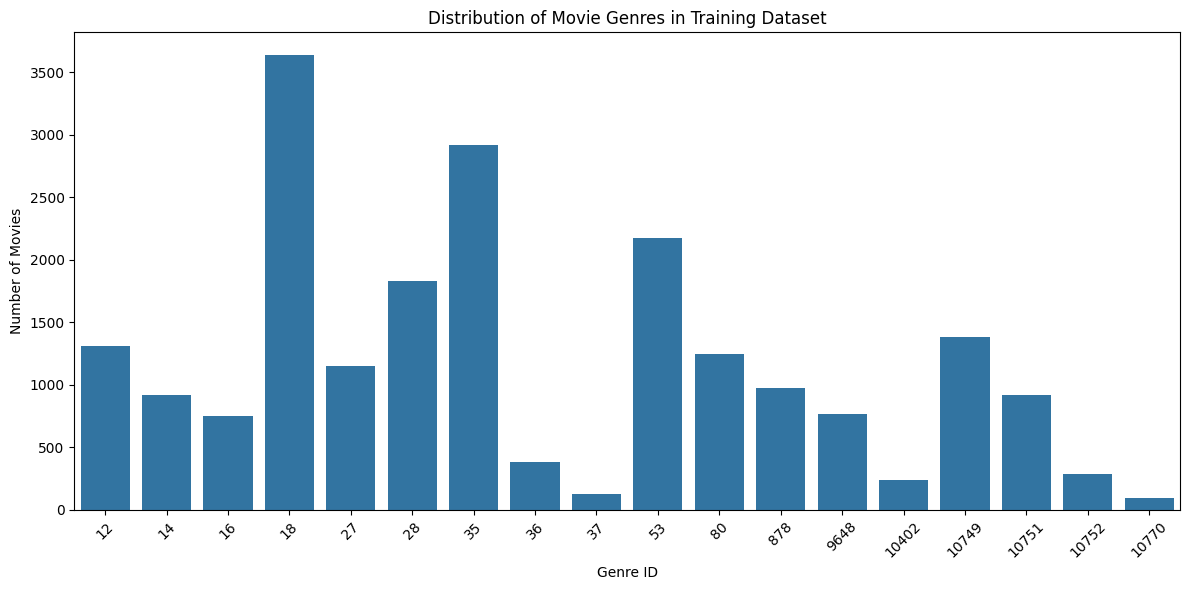

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count how many movies per genre appear in the full train dataset
genre_counts = y_train.sum(axis=0)
genre_names = [str(g) for g in mlb.classes_]

# Plot genre counts
plt.figure(figsize=(12,6))
sns.barplot(x=genre_names, y=genre_counts)
plt.xlabel('Genre ID')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Genres in Training Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Distribution of number of genres per movie

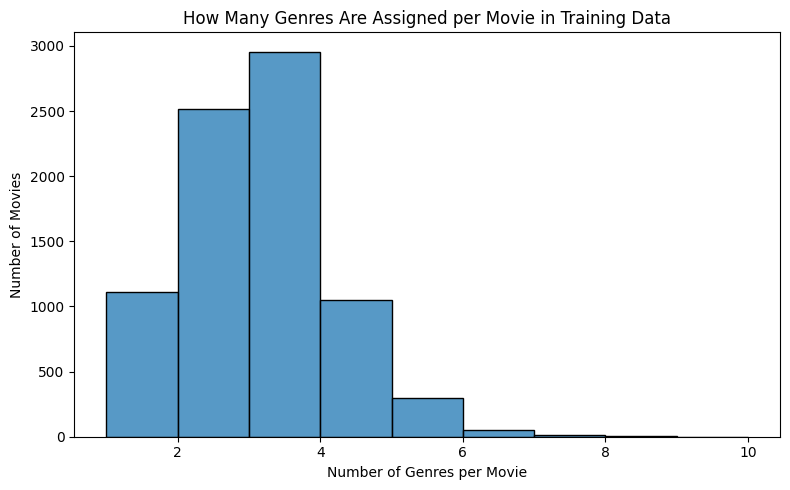

In [22]:
genre_per_movie = y_train.sum(axis=1)

plt.figure(figsize=(8,5))
sns.histplot(genre_per_movie, bins=range(1, max(genre_per_movie)+2), kde=False)
plt.xlabel('Number of Genres per Movie')
plt.ylabel('Number of Movies')
plt.title('How Many Genres Are Assigned per Movie in Training Data')
plt.tight_layout()
plt.show()


## Word cloud of the most common words in plot summaries

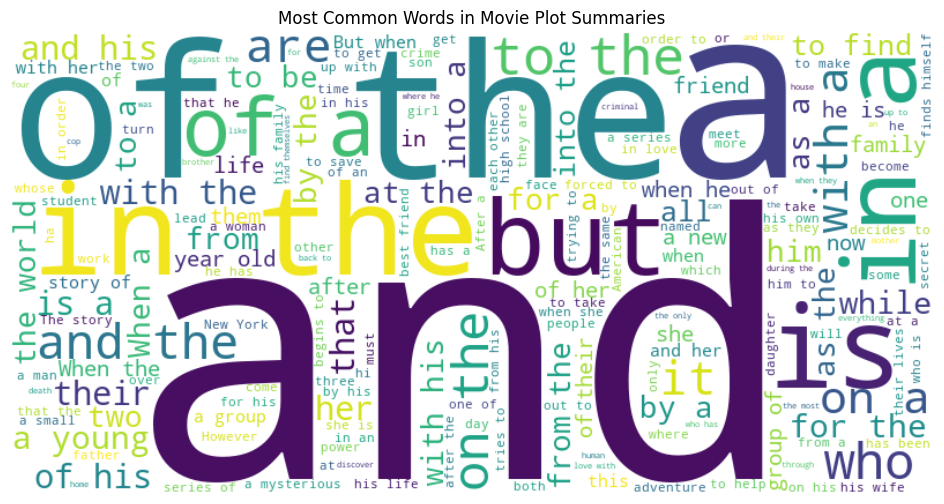

In [23]:
from wordcloud import WordCloud

# Combine all plot summaries into one text
all_text = " ".join(X_train_text)

# Create and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Movie Plot Summaries')
plt.show()


## Sample prediction visualization on test data

## Train multilabel classifier (OneVsRest with Logistic Regression)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Define classifier
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))

# Train classifier on training split
print("Training classifier...")
classifier.fit(X_train, y_train_split)
print("Training completed!")


Training classifier...
Training completed!


## Evaluate on validation set with classification report and confusion matrix

In [25]:
# Predict on validation set
y_val_pred = classifier.predict(X_val)

# Generate classification report
print("="*80)
print("CLASSIFICATION REPORT - Movie Genre Classification")
print("="*80)
print("\n")

# Classification report for multilabel classification
report = classification_report(
    y_val, y_val_pred,
    target_names=[f'Genre_{g}' for g in mlb.classes_],
    zero_division=0,
    output_dict=False
)
print(report)

# Also get dictionary format for detailed metrics
report_dict = classification_report(
    y_val, y_val_pred,
    target_names=[f'Genre_{g}' for g in mlb.classes_],
    zero_division=0,
    output_dict=True
)

# Print summary metrics
print("\n" + "="*80)
print("SUMMARY METRICS")
print("="*80)
print(f"Macro Average Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"Macro Average Recall: {report_dict['macro avg']['recall']:.4f}")
print(f"Macro Average F1-Score: {report_dict['macro avg']['f1-score']:.4f}")
print(f"Weighted Average Precision: {report_dict['weighted avg']['precision']:.4f}")
print(f"Weighted Average Recall: {report_dict['weighted avg']['recall']:.4f}")
print(f"Weighted Average F1-Score: {report_dict['weighted avg']['f1-score']:.4f}")
print("="*80)


CLASSIFICATION REPORT - Movie Genre Classification


              precision    recall  f1-score   support

    Genre_12       0.88      0.05      0.09       307
    Genre_14       0.88      0.04      0.07       200
    Genre_16       0.00      0.00      0.00       166
    Genre_18       0.71      0.61      0.65       720
    Genre_27       0.95      0.10      0.18       214
    Genre_28       0.85      0.25      0.39       372
    Genre_35       0.80      0.43      0.55       581
    Genre_36       0.00      0.00      0.00        82
    Genre_37       0.00      0.00      0.00        19
    Genre_53       0.79      0.19      0.30       430
    Genre_80       0.78      0.11      0.19       255
   Genre_878       1.00      0.11      0.20       200
  Genre_9648       0.50      0.01      0.02       159
 Genre_10402       0.00      0.00      0.00        39
 Genre_10749       0.85      0.15      0.25       263
 Genre_10751       0.83      0.03      0.05       197
 Genre_10752       1.00     

## Confusion Matrix Visualization for Each Genre

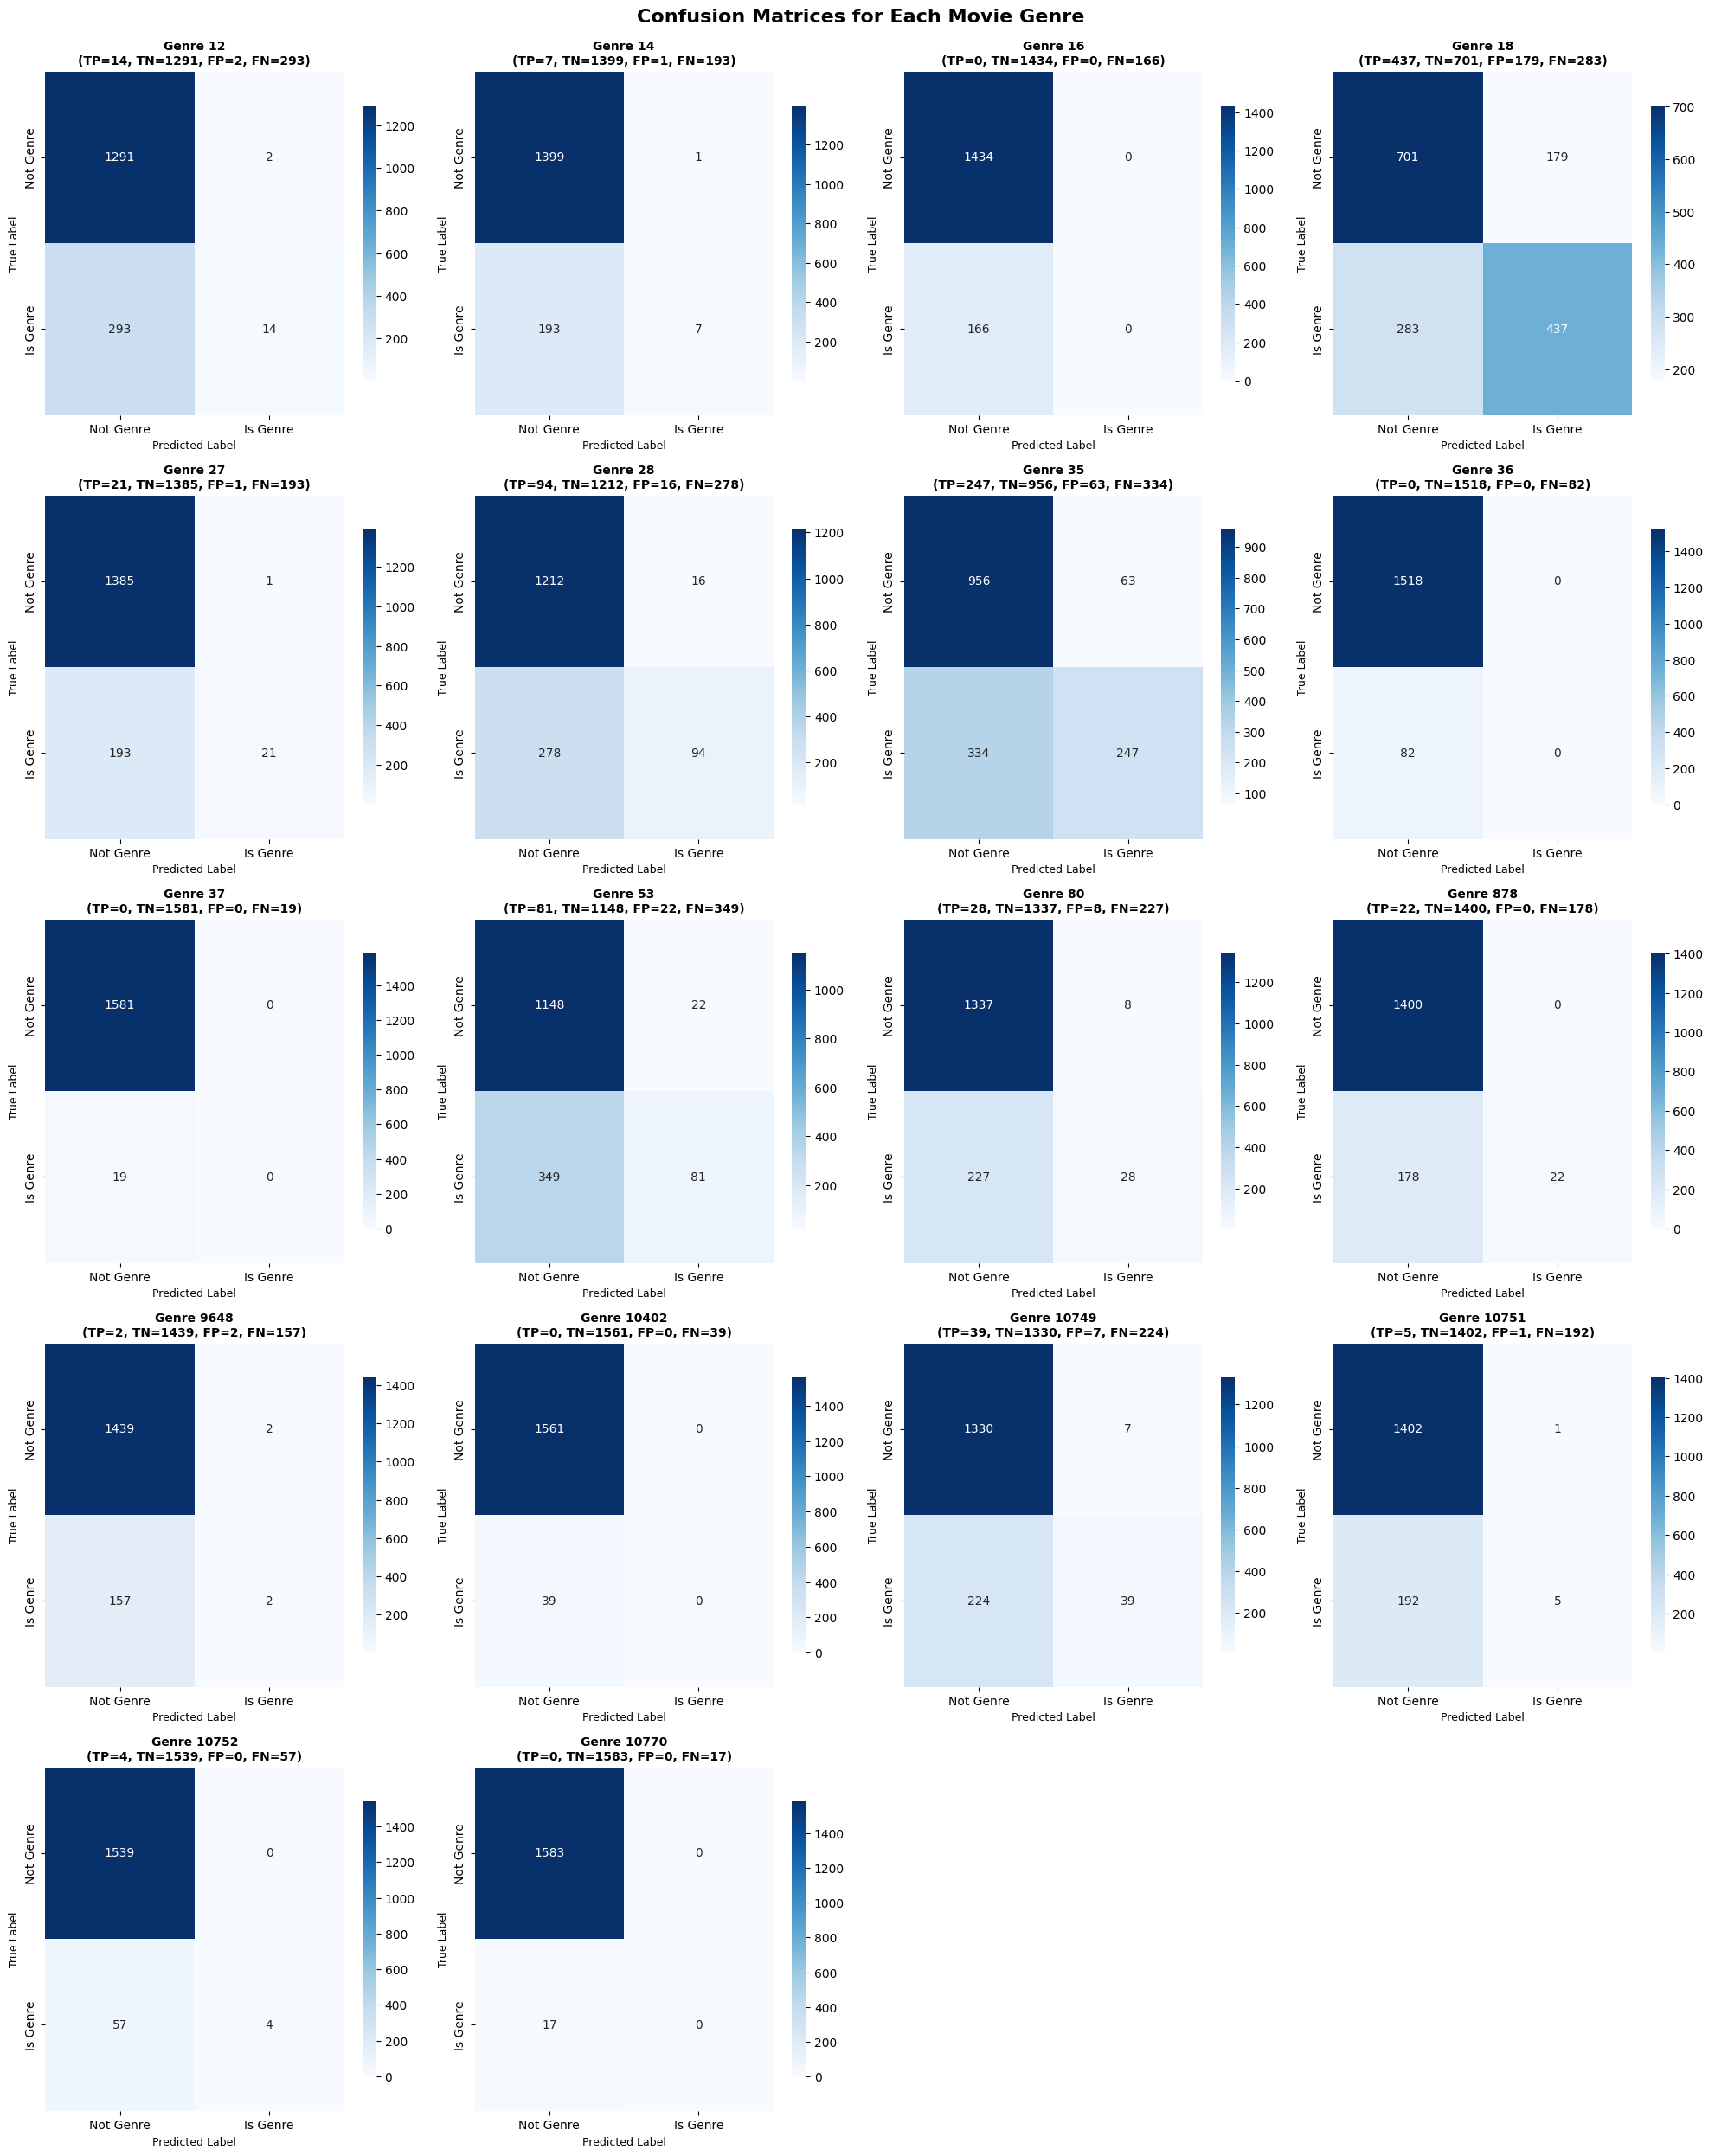


DETAILED CONFUSION MATRIX STATISTICS PER GENRE

Genre 12:
  True Positives (TP): 14
  True Negatives (TN): 1291
  False Positives (FP): 2
  False Negatives (FN): 293
  Precision: 0.8750
  Recall: 0.0456
  F1-Score: 0.0867
  Accuracy: 0.8156

Genre 14:
  True Positives (TP): 7
  True Negatives (TN): 1399
  False Positives (FP): 1
  False Negatives (FN): 193
  Precision: 0.8750
  Recall: 0.0350
  F1-Score: 0.0673
  Accuracy: 0.8788

Genre 16:
  True Positives (TP): 0
  True Negatives (TN): 1434
  False Positives (FP): 0
  False Negatives (FN): 166
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Accuracy: 0.8962

Genre 18:
  True Positives (TP): 437
  True Negatives (TN): 701
  False Positives (FP): 179
  False Negatives (FN): 283
  Precision: 0.7094
  Recall: 0.6069
  F1-Score: 0.6542
  Accuracy: 0.7113

Genre 27:
  True Positives (TP): 21
  True Negatives (TN): 1385
  False Positives (FP): 1
  False Negatives (FN): 193
  Precision: 0.9545
  Recall: 0.0981
  F1-Score: 0.1780
 

In [26]:
# Generate confusion matrices for each genre
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrices for each genre
n_genres = len(mlb.classes_)
n_cols = 4
n_rows = (n_genres + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_genres > 1 else [axes]

for idx, genre_id in enumerate(mlb.classes_):
    genre_idx = list(mlb.classes_).index(genre_id)
    
    # Get true and predicted labels for this genre
    y_true_genre = y_val[:, genre_idx]
    y_pred_genre = y_val_pred[:, genre_idx]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true_genre, y_pred_genre, labels=[0, 1])
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Genre', 'Is Genre'],
                yticklabels=['Not Genre', 'Is Genre'],
                cbar_kws={'shrink': 0.8})
    axes[idx].set_title(f'Genre {genre_id}\n(TP={cm[1,1]}, TN={cm[0,0]}, FP={cm[0,1]}, FN={cm[1,0]})', 
                        fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=9)
    axes[idx].set_xlabel('Predicted Label', fontsize=9)

# Hide unused subplots
for idx in range(n_genres, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices for Each Movie Genre', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print detailed confusion matrix statistics
print("\n" + "="*80)
print("DETAILED CONFUSION MATRIX STATISTICS PER GENRE")
print("="*80)
for idx, genre_id in enumerate(mlb.classes_):
    genre_idx = list(mlb.classes_).index(genre_id)
    y_true_genre = y_val[:, genre_idx]
    y_pred_genre = y_val_pred[:, genre_idx]
    cm = confusion_matrix(y_true_genre, y_pred_genre, labels=[0, 1])
    
    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    
    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    
    print(f"\nGenre {genre_id}:")
    print(f"  True Positives (TP): {TP}")
    print(f"  True Negatives (TN): {TN}")
    print(f"  False Positives (FP): {FP}")
    print(f"  False Negatives (FN): {FN}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
print("="*80)


In [27]:
## Retrain on full training data and predict on test set


In [28]:
# Retrain on full training dataset for final predictions
print("Retraining on full training dataset...")
final_classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
final_classifier.fit(X_train_full, y_train)
print("Retraining completed!")

# Prepare test data text features
X_test_text = test_df['overview'].fillna('')
X_test = tfidf.transform(X_test_text)

# Predict multilabel genres for test data
y_test_pred = final_classifier.predict(X_test)

# Convert back to genre ids
predicted_genres = []
for row in y_test_pred:
    genres = [str(mlb.classes_[i]) for i, val in enumerate(row) if val == 1]
    predicted_genres.append(', '.join(genres) if genres else 'No genres predicted')

# Add predictions to test dataframe
test_df['predicted_genreids'] = predicted_genres

print("\nSample predictions on test data:")
print("="*80)
test_df[['title', 'overview', 'predicted_genreids']].head(10)


Retraining on full training dataset...
Retraining completed!

Sample predictions on test data:


,title,overview,predicted_genreids
0,The Theory of Everything,The Theory of Everything is the extraordinary ...,"18, 35"
1,The Invisibles,"Following a city councils decision, a women's ...",18
2,A Haunted House 2,"After exorcising the demons of his ex, Malcolm...",No genres predicted
3,Mosul,"When ISIS took their homes, families and city,...","18, 28"
4,Letters to Juliet,An American girl on vacation in Italy finds an...,18
5,The Kissing Booth 2,"With college decisions looming, Elle juggles h...","18, 35, 10749"
6,U Turn,When a desperate man’s car breaks down in a bi...,"18, 53"
7,The Horse Whisperer,The mother of a severely traumatized daughter ...,18
8,Horizon: An American Saga - Chapter 1,"In 1859, families discover the lure of the Old...",18
9,Dora and the Lost City of Gold,"Dora, a girl who has spent most of her life ex...","12, 35, 10751"


In [29]:
# Show sample test plot summaries with predicted genres
print("="*80)
print("SAMPLE PREDICTIONS ON TEST DATA")
print("="*80)
for i in range(min(5, len(test_df))):
    print(f"\nMovie {i+1}:")
    print(f"Title: {test_df.iloc[i]['title']}")
    print(f"Plot summary:\n{test_df.iloc[i]['overview']}\n")
    print(f"Predicted genres: {test_df.iloc[i]['predicted_genreids']}\n")
    print('-'*80)


SAMPLE PREDICTIONS ON TEST DATA

Movie 1:
Title: The Theory of Everything
Plot summary:
The Theory of Everything is the extraordinary story of one of the world’s greatest living minds, the renowned astrophysicist Stephen Hawking, who falls deeply in love with fellow Cambridge student Jane Wilde.

Predicted genres: 18, 35

--------------------------------------------------------------------------------

Movie 2:
Title: The Invisibles
Plot summary:
Following a city councils decision, a women's shelter will soon be closed and social workers have only three months to accommodate the residents.

Predicted genres: 18

--------------------------------------------------------------------------------

Movie 3:
Title: A Haunted House 2
Plot summary:
After exorcising the demons of his ex, Malcolm starts afresh with his new girlfriend and her two children. After moving into their dream home, Malcolm is once again plagued by bizarre paranormal events.

Predicted genres: No genres predicted

-------

## Overall Model Performance Summary


In [30]:
# Create a summary dataframe of model performance per genre
performance_summary = []
for idx, genre_id in enumerate(mlb.classes_):
    genre_idx = list(mlb.classes_).index(genre_id)
    y_true_genre = y_val[:, genre_idx]
    y_pred_genre = y_val_pred[:, genre_idx]
    cm = confusion_matrix(y_true_genre, y_pred_genre, labels=[0, 1])
    
    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    
    performance_summary.append({
        'Genre_ID': genre_id,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy,
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN
    })

performance_df = pd.DataFrame(performance_summary)
print("\n" + "="*80)
print("PERFORMANCE SUMMARY BY GENRE")
print("="*80)
print(performance_df.to_string(index=False))
print("="*80)

# Save predictions to CSV
test_df[['movie_id', 'title', 'predicted_genreids']].to_csv('test_predictions.csv', index=False)
print("\nPredictions saved to 'test_predictions.csv'")



PERFORMANCE SUMMARY BY GENRE
 Genre_ID  Precision   Recall  F1-Score  Accuracy  TP   TN  FP  FN
       12   0.875000 0.045603  0.086687  0.815625  14 1291   2 293
       14   0.875000 0.035000  0.067308  0.878750   7 1399   1 193
       16   0.000000 0.000000  0.000000  0.896250   0 1434   0 166
       18   0.709416 0.606944  0.654192  0.711250 437  701 179 283
       27   0.954545 0.098131  0.177966  0.878750  21 1385   1 193
       28   0.854545 0.252688  0.390041  0.816250  94 1212  16 278
       35   0.796774 0.425129  0.554433  0.751875 247  956  63 334
       36   0.000000 0.000000  0.000000  0.948750   0 1518   0  82
       37   0.000000 0.000000  0.000000  0.988125   0 1581   0  19
       53   0.786408 0.188372  0.303940  0.768125  81 1148  22 349
       80   0.777778 0.109804  0.192440  0.853125  28 1337   8 227
      878   1.000000 0.110000  0.198198  0.888750  22 1400   0 178
     9648   0.500000 0.012579  0.024540  0.900625   2 1439   2 157
    10402   0.000000 0.000000  0